# Food Vision

In this project we develop a convolutional neural network which beats the 77.4% top-1 accuracy reported in [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment) using transfer learning.

The data that we will be using comes from the [Food-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset, which contains 101,000 images (75,750 for training and 25,250 for testing) belonging to 101 different food classes.

**Note:**
> * The project corresponds to milestone 1 of [this online class](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/).
> * The model was trained on Google Colab using a Tesla T4 GPU, and the results are stored in the folders `feature_extraction_model`, `fine_tuning_model`, and `training`. The default options in this notebook therefore allow to reload those previous results - instead of retraining the entire network, which takes a few hours.

## Loading the packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
print(np.__version__)
print(pd.__version__)
print(tf.__version__)

1.19.4
1.1.4
2.5.0


## Getting the data

We use the *load* function (from TensorFlow Datasets) to download the data and shuffle the images.

> **Note**: downloading the entire dataset (>5GB) takes several minutes.

In [2]:
# Get Food101 data
download_data = False # Set to True if you want to download the dataset on your hard drive
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             download=download_data,
                                             with_info=True)

The dataset comes already in tensor format and, as expected, we have 101 different classes:

In [3]:
# Dataset features
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [4]:
# Check the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Visualizing a sample image

Let's have a look at a sample image:

In [5]:
# Take one sample of train data
train_one_sample = train_data.take(1)
train_one_sample # Samples are in the format (image_tensor, label)

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [6]:
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image type: {image.dtype}
    Image class: {label}
    Class name: {class_names[label.numpy()]}
    """)


    Image shape: (384, 512, 3)
    Image type: <dtype: 'uint8'>
    Image class: 85
    Class name: samosa
    


In [7]:
tf.reduce_min(image), tf.reduce_max(image) # Image has values in [0, 255]

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

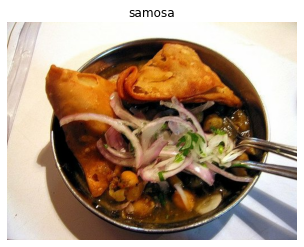

In [8]:
# Plot the image
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Preprocessing

Since the images have different sizes and are stored as `uint8` tensor, we will use the function defined below to resize the images and casts them to `float32`.

> **Note:** the EfficientNetB0 that we will use below already contains a rescaling layer, so there is no need to rescale the images in [0, 1].

In [9]:
# Create preprocessing function
def preprocess_img(image, label, img_size=224, rescale=False):
    """
    Convert image from 'uint8' -> 'float32' and reshapes it to
    [img_shape, img_shape, 3]
    If rescale=True the image is rescaled to [0, 1]
    """
    image = tf.image.resize(image, [img_size, img_size])
    if rescale:
        image /= 255.
    return tf.cast(image, tf.float32), label

In [10]:
# Apply preprocess_img to all images
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data, turn it into batches, and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Same steps for test set (but no need to shuffle)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

After the previous step, the training and test sets are ready to be fed to the neural network model.

In [11]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Training Part 1 - Feature Extraction Model

For this project we will make use of transfer learning, which means that we'll be using a model that has been pretrained on a different dataset. In order to make it work on our own dataset, we will:

1. Replace the topmost layer of the pretrained model with a new layer and train for a few epochs while keeping the lower layers frozen (the feature extraction model).

2. Unfreeze the lower layers and train for a few more epochs (this will allow us to fine tune the weights of the entire network).

In [12]:
# Create model (feature extraction)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224, 224, 3)

# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # Freeze layers of base model

# Define model via functional API
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # Do NOT train this!
x = layers.GlobalAveragePooling2D(name="pooling2D")(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              # NOTE: 0.001 is default value for learning rate
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

In [13]:
# Let's have a look at the model structure
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling2D (GlobalAveragePool (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [14]:
# Check that base model is indeed frozen
for layer in model.layers:
    print(f"{layer.name}: trainable? {layer.trainable}")

input_layer: trainable? True
efficientnetb0: trainable? False
pooling2D: trainable? True
dense: trainable? True


Time to fit the model! In order to keep training time low, we will train for 3 epochs and validate the model using only 15% of the test set.

> **Note:** Keeping `train_model = False` in the cell below will allow us to reload the model trained on Google Colab.

In [15]:
# Fit feature extraction model
train_model = False
if train_model:
    # NOTE: on Colab with a Tesla T4, training for 3 epochs takes ~10 minutes (with checkpoints)
    history_1 = model.fit(train_data,
                          epochs=3,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          # Only 15% of data to speed up training time
                          validation_steps=int(0.15 * len(test_data)))
else:
    model = tf.keras.models.load_model("feature_extraction_model")
    history_1 = pd.read_csv("training/history1.csv")

### Visualizing the Training Curves (Feature Extraction Model)

In [16]:
# Make font bigger and change color scheme
plt.rcParams.update({'font.size': 16})
plt.style.use('seaborn-colorblind')

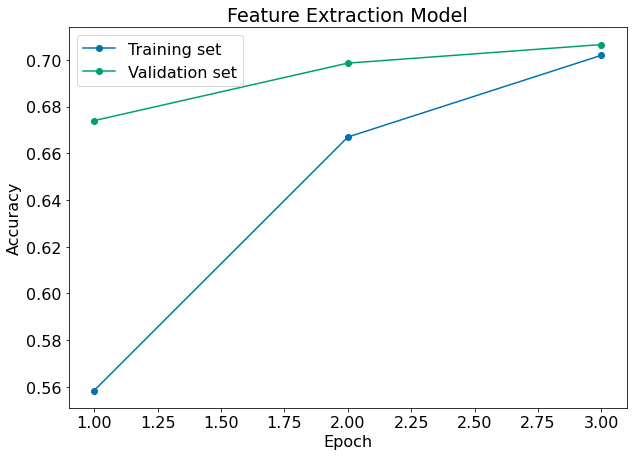

In [17]:
# NOTE: validation accuracy was computed only on 15% of test set
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(history_1.index + 1, history_1["accuracy"],
        marker="o", label="Training set")
ax.plot(history_1.index + 1, history_1["val_accuracy"],
        marker="o", label="Validation set")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Feature Extraction Model")
ax.legend();

In [18]:
# Evaluate on full test set (70.37% accuracy)
# NOTE: this takes >10 minutes without a GPU
# model.evaluate(test_data)

## Training Part 2 - Fine Tuning

The overall accuracy on the test set is already good (70.37%). Let's now fine-tune the model weights to improve the performance even further.

In [19]:
# Make all layers trainable
model.trainable = True

In [20]:
for layer in model.layers:
    print(f"{layer.name}: trainable? {layer.trainable}")

input_layer: trainable? True
efficientnetb0: trainable? True
pooling2D: trainable? True
dense_4: trainable? True


In [21]:
# Reduce learning rate by 10x (0.001 -> 0.0001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

For the fine tuning, we will create an early-stopping callback and train for a maximum of 100 epochs. As before, the model is validated using only 15% of the test set.

> **Note:** As above, keeping `fine_tune = False` in the cell below will allow us to load the model trained on Google Colab.

In [22]:
# Perform fine tuning
fine_tune = False
if fine_tune:
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3,
                                                  restore_best_weights=True,
                                                  verbose=0)
    # This takes ~2 hours with a Tesla T4 (early stops at epoch 9)
    history_2 = model.fit(train_data,
                          epochs=100,
                          steps_per_epoch=len(train_data),
                          callbacks=[early_stop],
                          validation_data=test_data,
                          # Again, only 15% of data to speed up running time
                          validation_steps=int(0.15 * len(test_data)))
else:
    model = tf.keras.models.load_model("fine_tuning_model")
    history_2 = pd.read_csv("training/history2.csv")

### Visualizing the Training Curves (Fine Tuning)

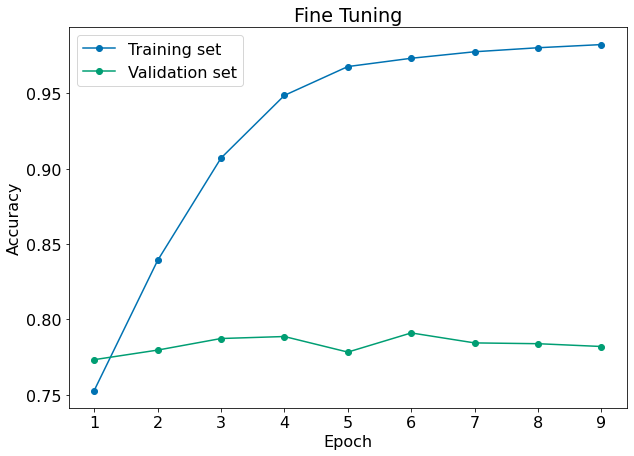

In [23]:
# NOTE: validation accuracy was computed only on 15% of validation set
# Validation accuracy peaks at epochs 6 then decreases (overfitting)
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(history_2.index + 1, history_2["accuracy"],
        marker="o", label="Training set")
ax.plot(history_2.index + 1, history_2["val_accuracy"],
        marker="o", label="Validation set")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Fine Tuning")
ax.legend();

It seems that the model is starting to overfit the training data. However, fine tuning its weights boost the overall accuracy (on the full test set) from 70.3% to 78.26%, which is almost 1% point above the 77.4% accuracy reported in DeepFood!

In [24]:
# Evaluate on full test set (78.26% accuracy)
# model.evaluate(test_data)

## Model Evaluation

Instead of overall accuracy, let's now have a look at the performance of the model on individual classes.

> **Note:** keeping `load_original = True` in the cell below allows us to load the original model predictions instead of recomputing them.

In [25]:
# Predict classes
load_original = True
if load_original:
    preds = pd.read_csv("training/preds.csv")
else:
    # Get true and predicted classes
    y_true = np.array([], dtype="int")
    y_pred = np.array([], dtype="int")
    for curr, (images, labels) in enumerate(test_data):
        pred_probs = loaded_model.predict(images)
        pred_classes = pred_probs.argmax(axis=1)
        y_true = np.concatenate([y_true, labels.numpy()])
        y_pred = np.concatenate([y_pred, pred_classes])
    preds = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})

In [26]:
# Check that the top-1 accuracy is what we expect
sum(preds["y_true"] == preds["y_pred"]) / len(preds)

0.7826138613861386

To check the performance on each class of food, let's have compute the f1-score for each class.

> **Note:** The f1-score is simply the [harmonic mean of precision and recall](https://en.wikipedia.org/wiki/F-score).

In [27]:
# Let's look at the f1 score for each class
from sklearn.metrics import classification_report
report_d = classification_report(preds["y_true"], preds["y_pred"], output_dict=True)

In [28]:
# Create a dataframe with class names and f1-scores
f1_scores = pd.DataFrame({"class": class_names,
                          "f1-score": np.zeros(len(class_names))})
for k, v in report_d.items():
    if k == "accuracy":
        break
    f1_scores.loc[int(k), "f1-score"] = v["f1-score"]
f1_scores = f1_scores.sort_values("f1-score", ascending=False)
f1_scores

,class,f1-score
33,edamame,0.985859
63,macarons,0.948665
69,oysters,0.929293
54,hot_and_sour_soup,0.918033
64,miso_soup,0.908316
...,...,...
26,crab_cakes,0.600924
82,ravioli,0.593301
39,foie_gras,0.590164
77,pork_chop,0.580645


Let's now visualize the results using seaborn.

In [29]:
import seaborn as sns

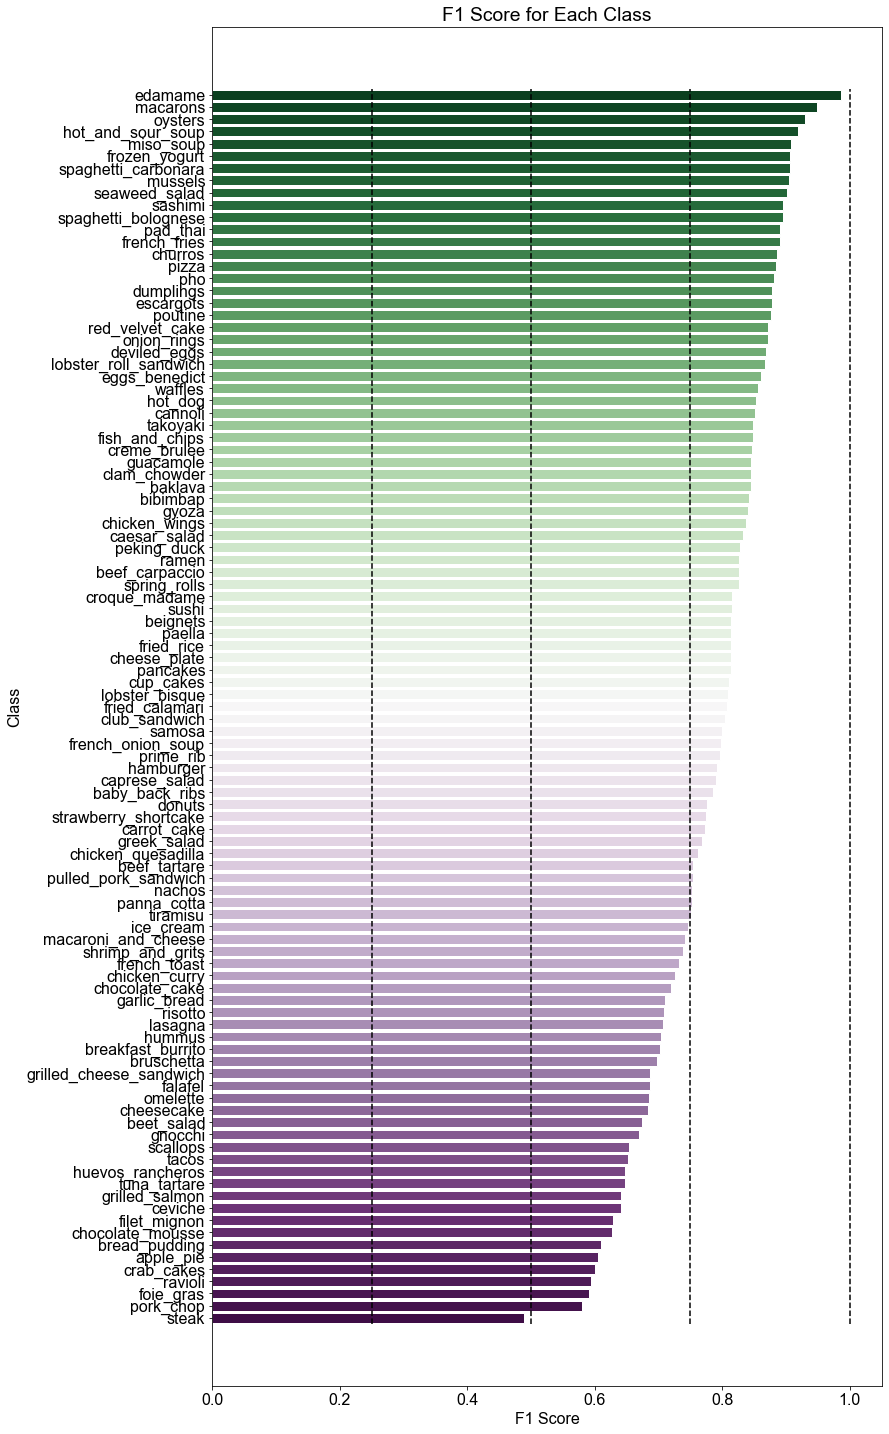

In [30]:
fig, ax = plt.subplots(figsize=(12, 25))
sns.set_style("white")
sns.barplot(x="f1-score", y="class", data=f1_scores, palette="PRGn_r", ax=ax)
# Add vertical bars
plt.vlines(x=[0.25, 0.5, 0.75, 1.0], ymin=plt.ylim()[0], ymax=plt.ylim()[1],
           colors="black", linestyles="dashed")
# Set labels and title
ax.set(xlabel="F1 Score", ylabel="Class");
ax.set_title("F1 Score for Each Class");

Interesting! It looks like our model performs really well on edamame and macarons, but not so much on pork chops and steaks.